In [5]:
import pandas as pd
import json
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 22})


In [10]:
def get_SUB_metering_data(dict_sub_data, date, feeder):
    sub_data=[dict_sub_data[feeder]['P_MW'][date][hour] for hour in [str(x) for x in sorted([int(y) for y in list(dict_sub_data[feeder]['P_MW'][date].keys())])]]        
    return sub_data

In [3]:
# descript number of AMR customer per feeder
df_1=pd.read_excel('raw_files/meterpoint_with_feeder.xlsx', sheet_name='Sheet1')
df_2=pd.read_csv('raw_files/peano_with_feeder.csv')


dict_meteringpoint={}
for feeder in list(set(df_1['feeder'])):
    df_temp=df_1.drop(list(np.where(df_1['feeder']!=feeder)[0])).copy()
    df_temp=df_temp.reset_index(drop=True)
    df_temp_2=df_2.drop(list(np.where(df_2['feeder']!=feeder)[0])).copy()
    df_temp_2=df_temp_2.reset_index(drop=True)

    number_AMR=len(df_temp['METERPOINTID'])
    number_customer=len(df_temp_2['PEANO'])
    list_meteringpoint_name=[x for x in list(df_temp['METERPOINTID'])]
    list_CTM=[x for x in list(df_temp['CTM'])]
    list_CTD=[x for x in list(df_temp['CTD'])]
    dict_meteringpoint.update({feeder:{'number_customer':number_customer, 'number_AMR':number_AMR, 'AMR_meterinpoint':list_meteringpoint_name, 
                               'CTM':list_CTM, 'CTD':list_CTD}})
    

# list of blank feeder = ['NIA07']

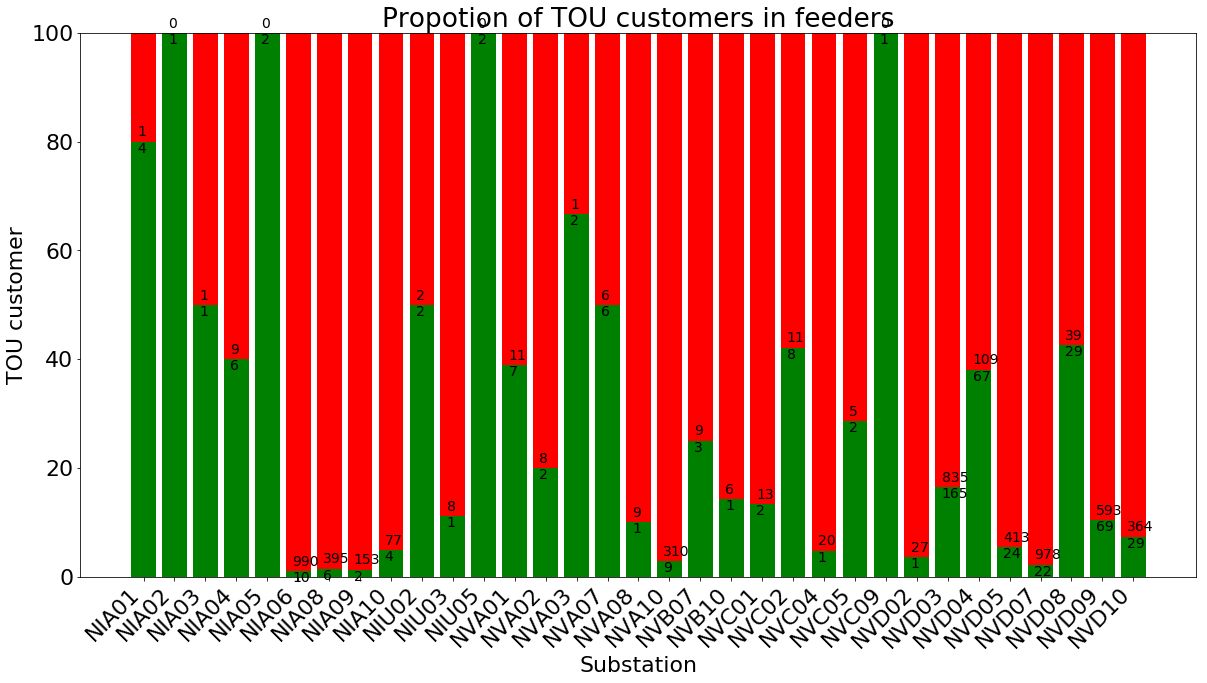

In [6]:
list_feeder_name=sorted(list(dict_meteringpoint.keys()))
number_customer=np.array([dict_meteringpoint[feeder_name]['number_customer'] for feeder_name in list_feeder_name])
number_AMR_customer=np.array([dict_meteringpoint[feeder_name]['number_AMR'] for feeder_name in list_feeder_name])
non_AMR_customer=number_customer-number_AMR_customer

ind = [x for x, _ in enumerate(list_feeder_name)]
propotion_AMR=np.true_divide(number_AMR_customer, number_customer) *100
propotion_non_AMR=np.true_divide(non_AMR_customer, number_customer) *100

plt.bar(ind, propotion_non_AMR, width=0.8, label='TOU', color='r', bottom=propotion_AMR)
plt.bar(ind, propotion_AMR, width=0.8, label='TOU', color='g')


for index,data in enumerate(number_AMR_customer):
    plt.text(x=index-0.2 , y=propotion_AMR[index]-2 , s=f"{data}" , fontdict=dict(fontsize=14))
    
for index,data in enumerate(non_AMR_customer):
    plt.text(x=index-0.2 , y=100-propotion_non_AMR[index]+1 , s=f"{data}" , fontdict=dict(fontsize=14))

plt.xticks(ind, list_feeder_name)
plt.ylabel("TOU customer")
plt.xlabel("Substation")
plt.title("Propotion of TOU customers in feeders")
plt.ylim=1.0

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()


# Combine substation data and AMR data

In [7]:
list_sub_name=['NIA', 'NIB', 'NIC']

In [8]:
#read substation file
with open('raw_files/dict_N1_NIA.json') as json_file:  
    sub_data = json.load(json_file)

In [11]:
df_NIA=pd.DataFrame()
list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

#create date column
df_NIA['Date']=sorted(list(sub_data['OUT01']['P_MW'].keys()))
df_NIA['Month'] = [x.split("/")[0] for x in list(df_NIA['Date'])]
df_NIA['Month'] = [str(x).zfill(2) for x in list(df_NIA['Month'])]

df_NIA['Day'] = [x.split("/")[1] for x in list(df_NIA['Date'])]
df_NIA['Day'] = [str(x).zfill(2) for x in list(df_NIA['Day'])]

df_NIA['Year'] = [x.split("/")[2] for x in list(df_NIA['Date'])]
df_NIA['Year'] = [str(x).zfill(2) for x in list(df_NIA['Year'])]

#create feeders data columns
for feeder in list_feeder:
    df_NIA['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIA['Date'])]
    
print(df_NIA.head())

        Date Month Day  Year  \
0   1/1/2018    01  01  2018   
1   1/1/2019    01  01  2019   
2  1/10/2018    01  10  2018   
3  1/10/2019    01  10  2019   
4  1/11/2018    01  11  2018   

                                           SUB_OUT01  \
0  [1.0940299999999998, 1.0940299999999998, 0.962...   
1  [1.080849, 1.080849, 1.080849, 1.080849, 1.080...   
2  [1.344471, 1.344471, 1.344471, 1.344471, 1.384...   
3  [1.858534, 1.581731, 1.713542, 1.818991, 1.818...   
4  [1.291747, 1.291747, 1.291747, 1.291747, 1.291...   

                                           SUB_OUT02  \
0  [0.540316, 0.380504, 0.380504, 0.380504, 0.380...   
1  [0.509876, 0.509876, 0.509876, 0.509876, 0.509...   
2  [4.413855, 3.98769, 4.451905, 4.512786, 4.5203...   
3  [3.363662, 3.5843550000000004, 4.200772, 3.805...   
4  [4.383415, 4.391025, 4.429075, 4.177942, 4.261...   

                                           SUB_OUT03  \
0  [1.019752, 1.019752, 1.042583, 0.8827709999999...   
1  [0.266353, 0.26635

In [12]:
#read kWhr file
with open('raw_kwhr_2018_2019_dict.json') as json_file:  
    meter_data = json.load(json_file)

In [13]:
# from dict_meteringpoint

list_of_feeder=['NIA01', 'NIA02', 'NIA03', 'NIA04', 'NIA05', 'NIA06', 'NIA08', 'NIA09', 'NIA10']
# list_of_feeder= ['NIA01']

for feeder in list_of_feeder:
    list_AMR_meteringpoint_in_feeder=[]
    for day, month, year in zip(list(df_NIA['Day']),list(df_NIA['Month']),list(df_NIA['Year'])):
        list_AMR_meteringpoint_in_day=[]
        for AMR_meteringpoint in dict_meteringpoint[feeder]['AMR_meterinpoint']:
            if year in meter_data[str(AMR_meteringpoint)].keys():
                if month in meter_data[str(AMR_meteringpoint)][year].keys():
                    if day in meter_data[str(AMR_meteringpoint)][year][month].keys():
                        list_AMR_meteringpoint_in_day.append({AMR_meteringpoint: [meter_data[str(AMR_meteringpoint)][year][month][day][x] for x in sorted(list(meter_data[str(AMR_meteringpoint)][year][month][day].keys()))]})    
        list_AMR_meteringpoint_in_feeder.append(list_AMR_meteringpoint_in_day)
    df_NIA['AMR_{}'.format(feeder)]=list_AMR_meteringpoint_in_feeder



In [14]:
print(df_NIA.head())

        Date Month Day  Year  \
0   1/1/2018    01  01  2018   
1   1/1/2019    01  01  2019   
2  1/10/2018    01  10  2018   
3  1/10/2019    01  10  2019   
4  1/11/2018    01  11  2018   

                                           SUB_OUT01  \
0  [1.0940299999999998, 1.0940299999999998, 0.962...   
1  [1.080849, 1.080849, 1.080849, 1.080849, 1.080...   
2  [1.344471, 1.344471, 1.344471, 1.344471, 1.384...   
3  [1.858534, 1.581731, 1.713542, 1.818991, 1.818...   
4  [1.291747, 1.291747, 1.291747, 1.291747, 1.291...   

                                           SUB_OUT02  \
0  [0.540316, 0.380504, 0.380504, 0.380504, 0.380...   
1  [0.509876, 0.509876, 0.509876, 0.509876, 0.509...   
2  [4.413855, 3.98769, 4.451905, 4.512786, 4.5203...   
3  [3.363662, 3.5843550000000004, 4.200772, 3.805...   
4  [4.383415, 4.391025, 4.429075, 4.177942, 4.261...   

                                           SUB_OUT03  \
0  [1.019752, 1.019752, 1.042583, 0.8827709999999...   
1  [0.266353, 0.26635

# convert to primary kWhr

In [15]:
# get current ratios
metering_df=pd.read_excel('raw_files/meterpoint_with_feeder.xlsx')


In [20]:
dict_meteringpoint_temp={x:{'CTM':y, 'CTD':z}for x,y,z in zip(list(metering_df['METERPOINTID']), list(metering_df['CTM']), list(metering_df['CTD']))}

In [21]:



dict_meteringpoint_temp

{21652: {'CTM': 250, 'CTD': 5},
 136898: {'CTM': 150, 'CTD': 5},
 137091: {'CTM': 150, 'CTD': 5},
 137138: {'CTM': 150, 'CTD': 5},
 42432: {'CTM': 150, 'CTD': 5},
 66543: {'CTM': 400, 'CTD': 5},
 21654: {'CTM': 400, 'CTD': 5},
 42421: {'CTM': 400, 'CTD': 5},
 42422: {'CTM': 150, 'CTD': 5},
 42423: {'CTM': 150, 'CTD': 5},
 43958: {'CTM': 400, 'CTD': 5},
 137110: {'CTM': 400, 'CTD': 5},
 21655: {'CTM': 400, 'CTD': 5},
 42431: {'CTM': 400, 'CTD': 5},
 44834: {'CTM': 150, 'CTD': 5},
 56452: {'CTM': 150, 'CTD': 5},
 56457: {'CTM': 400, 'CTD': 5},
 56458: {'CTM': 400, 'CTD': 5},
 124642: {'CTM': 150, 'CTD': 5},
 124647: {'CTM': 150, 'CTD': 5},
 124649: {'CTM': 150, 'CTD': 5},
 124656: {'CTM': 150, 'CTD': 5},
 124683: {'CTM': 400, 'CTD': 5},
 185767: {'CTM': 250, 'CTD': 5},
 56448: {'CTM': 250, 'CTD': 5},
 136900: {'CTM': 150, 'CTD': 5},
 137094: {'CTM': 150, 'CTD': 5},
 164978: {'CTM': 150, 'CTD': 5},
 189318: {'CTM': 150, 'CTD': 5},
 193781: {'CTM': 150, 'CTD': 5},
 44318: {'CTM': 250, 'CTD

In [22]:
df_AMR_data=pd.DataFrame()
df_AMR_data['Month']=df_NIA['Month']
df_AMR_data['Day']=df_NIA['Day']
df_AMR_data['Year']=df_NIA['Year']

for out_num in ['01','02','03','04','05','06','08','09','10']:

    df_AMR_data['AMR_OUT{}'.format(out_num)]=[[{list(AMR_data.keys())[0]:np.array([AMR_data[list(AMR_data.keys())[0]]])/dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTM']*dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTD']} for AMR_data in date_data] for date_data in df_NIA['AMR_NIA{}'.format(out_num)]]

    
# df_AMR_data['SUM_AMR_OUT01']

for feeder in ['01','02','03','04','05','06','08','09','10']:
    print(feeder)
    list_sum_AMR_feeder=[]
    for x in df_AMR_data['AMR_OUT{}'.format(feeder)]:
#         print('new date')
        list_sum_AMR_date=[]
        bad_date=0
        sum_AMR_data=np.zeros(shape=(1,96))
        for y in x:
            if len(y[list(y.keys())[0]][0]) == 96:
                sum_AMR_data = sum_AMR_data+y[list(y.keys())[0]]
            else: 
                bad_data=1
        if bad_date==0:
            list_sum_AMR_date.append(sum_AMR_data)
        else:
            list_sum_AMR_date.append('None')
        list_sum_AMR_feeder.append(list_sum_AMR_date)
    df_AMR_data['SUM_AMR_OUT{}'.format(feeder)]=list_sum_AMR_feeder

    
    
sum_AMR_load=[]
for a,b,c, d,e,f, g,h,i in zip(df_AMR_data['SUM_AMR_OUT01'], df_AMR_data['SUM_AMR_OUT02'], df_AMR_data['SUM_AMR_OUT03'],
                              df_AMR_data['SUM_AMR_OUT04'], df_AMR_data['SUM_AMR_OUT05'], df_AMR_data['SUM_AMR_OUT06'],
                              df_AMR_data['SUM_AMR_OUT08'], df_AMR_data['SUM_AMR_OUT09'], df_AMR_data['SUM_AMR_OUT10']):
    sum_AMR_load.append([a[0]+b[0]+c[0]+d[0]+e[0]+f[0]+g[0]+h[0]+i[0]])
df_AMR_data['SUM_AMR_LOAD']=sum_AMR_load
print(df_AMR_data.head())

01
02
03
04
05
06
08
09
10
  Month Day  Year                                          AMR_OUT01  \
0    01  01  2018  [{21652: [[1.51603212e-02 1.47840012e-02 1.470...   
1    01  01  2019  [{21652: [[0.02771328 0.02763264 0.027552   0....   
2    01  10  2018  [{21652: [[3.25868954 0.02327808 3.86018334 3....   
3    01  10  2019  [{21652: [[2.65730325e+00 2.93529623e-02 2.913...   
4    01  11  2018  [{21652: [[2.90414231e+00 2.13158417e-02 3.858...   

                                           AMR_OUT02  \
0  [{42432: [[2.08624656 2.05569296 2.03754896 1....   
1  [{42432: [[1.89181455 1.91304975 1.82300174 1....   
2  [{42432: [[ 2.5147138   2.5413698   2.37888019...   
3  [{42432: [[2.08225936 2.12580497 1.74746894 1....   
4  [{42432: [[ 2.46503059  2.36942739  2.28856338...   

                                           AMR_OUT03  \
0  [{66543: [[0.22567442 0.21693842 0.21828242 0....   
1  [{66543: [[0.16789921 0.17063761 0.16643761 0....   
2  [{66543: [[0.18963841 0.19121762

In [ ]:
#calculate load factor

In [23]:

df_AMR_data['LF_SUB']=[x[0].mean()/x[0].max() if x[0].max()!=0 else 'None' for x in df_AMR_data['SUM_AMR_LOAD']]


for feeder in ['01','02','03','04','05','06','08','09','10']:
    df_AMR_data['LF_OUT{}'.format(feeder)]=[x[0].mean()/x[0].max() if x[0].max()!=0 else 'None' for x in df_AMR_data['SUM_AMR_OUT{}'.format(feeder)]]

In [24]:
df_AMR_data

,Month,Day,Year,AMR_OUT01,AMR_OUT02,AMR_OUT03,AMR_OUT04,AMR_OUT05,AMR_OUT06,AMR_OUT08,...,LF_SUB,LF_OUT01,LF_OUT02,LF_OUT03,LF_OUT04,LF_OUT05,LF_OUT06,LF_OUT08,LF_OUT09,LF_OUT10
0,01,01,2018,[{21652: [[1.51603212e-02 1.47840012e-02 1.470...,[{42432: [[2.08624656 2.05569296 2.03754896 1....,[{66543: [[0.22567442 0.21693842 0.21828242 0....,[{21654: [[4.56960036e-03 4.51920036e-03 4.485...,[{21655: [[0.06733441 0.06597361 0.06636001 0....,[{44834: [[0.57778565 0.51717124 0.56470404 0....,[{56448: [[0.72815238 0.60867077 0.68420357 0....,...,None,None,None,None,None,None,None,None,None,None
1,01,01,2019,[{21652: [[0.02771328 0.02763264 0.027552 0....,[{42432: [[1.89181455 1.91304975 1.82300174 1....,[{66543: [[0.16789921 0.17063761 0.16643761 0....,[{21654: [[6.06480048e-03 1.00464008e-02 5.292...,[{21655: [[0.09364321 0.09305521 0.08875441 0....,[{44834: [[0.63571205 0.60869765 0.59422725 0....,[{56448: [[0.60423557 0.62576645 0.5486746 0....,...,0.639549,0.29099,0.752259,0.486001,0.224956,0.490733,0.575506,0.658541,0.462772,0.376856
2,01,10,2018,[{21652: [[3.25868954 0.02327808 3.86018334 3....,[{42432: [[ 2.5147138 2.5413698 2.37888019...,[{66543: [[0.18963841 0.19121762 0.17545921 0....,[{21654: [[0.00672 0.0067368 0.0064176 0....,[{21655: [[0.07395361 0.07413841 0.07077841 0....,[{44834: [[1.2836993 1.2834305 1.02394888 1....,[{56448: [[1.37483147 1.39687307 1.12366473 1....,...,0.747476,0.5791,0.491367,0.401227,0.433231,0.471917,0.615212,0.556935,0.655251,0.521397
3,01,10,2019,[{21652: [[2.65730325e+00 2.93529623e-02 2.913...,[{42432: [[2.08225936 2.12580497 1.74746894 1....,[{66543: [[0.16813441 0.17206561 0.16531201 0....,[{21654: [[0.0079968 0.0058464 0.0058296 0.005...,[{21655: [[0.09009841 0.09134161 0.08878801 0....,[{44834: [[1.3149697 1.2612545 1.61714573 1....,[{56448: [[1.11847689 1.07662472 0.88849159 0....,...,0.757397,0.570415,0.501056,0.402885,0.582112,0.49024,0.575904,0.528726,0.50145,0.387578
4,01,11,2018,[{21652: [[2.90414231e+00 2.13158417e-02 3.858...,[{42432: [[ 2.46503059 2.36942739 2.28856338...,[{66543: [[0.18024721 0.17589601 0.17564401 0....,[{21654: [[5.74560045e-03 5.76240045e-03 5.745...,[{21655: [[0.07563361 0.07780081 0.07494481 0....,[{44834: [[1.42392331 1.48090892 1.15153929 1....,[{56448: [[1.46536332 1.34663435 1.18624137 1....,...,0.701144,0.596035,0.354724,0.308397,0.486199,0.395537,0.613184,0.591052,0.583948,0.546364
5,01,11,2019,[{21652: [[3.86655390e+00 1.21629322e+00 3.869...,[{42432: [[1.89696655 1.86399375 1.87120655 1....,[{66543: [[0.17401441 0.17606401 0.16937761 0....,[{21654: [[0.0059304 0.0059136 0.0070728 0.010...,[{21655: [[0.09219841 0.09149281 0.08823361 0....,[{44834: [[1.41751691 1.35640971 1.2500545 1....,[{56448: [[1.23131914 1.16780169 0.95163271 0....,...,0.769053,0.593683,0.479702,0.37521,0.602455,0.464008,0.622426,0.553768,0.580217,0.39943
6,01,12,2018,[{21652: [[3.15307801e+00 2.12352017e-02 3.850...,[{42432: [[3.05410584 2.98247063 2.18919697 2....,[{66543: [[0.15929761 0.15603841 0.15583681 0....,[{21654: [[5.34240042e-03 5.34240042e-03 5.376...,[{21655: [[0.07375201 0.06985441 0.07121521 0....,[{44834: [[1.18961929 1.11319049 1.08523529 1....,[{56448: [[1.41480203 1.38300299 0.99082376 0....,...,0.757475,0.582156,0.678603,0.256064,0.488233,0.401711,0.566761,0.599875,0.466276,0.578013
7,01,12,2019,[{21652: [[3.85652766e+00 1.57640460e+00 3.013...,[{42432: [[1.69832333 1.78675854 1.77914254 1....,[{66543: [[0.17797921 0.17650081 0.17826481 0....,[{21654: [[0.010584 0.0101472 0.005796 0.005...,[{21655: [[0.09251761 0.09134161 0.08966161 0....,[{44834: [[2.13140497 1.58000652 1.3165825 1....,[{56448: [[1.04821256 0.96931976 1.002194 1....,...,0.805653,0.559258,0.456048,0.409489,0.655269,0.658989,0.616108,0.571372,0.557806,0.353409
8,01,13,2018,[{21652: [[1.62161677 3.87994015 0.02475648 0....,[{42432: [[2.05900816 2.01591056 2.09641616 2....,[{66543: [[0.16593361 0.16784881 0.16401841 0....,[{21654: [[6.66960052e-03 6.70320053e-03 6.636...,[{21655: [[0.07299601 0.

In [685]:
df_AMR_data.to_excel("AMR_DATA_COMBINE_SUB.xlsx", sheet_name='Sheet_name_1')  # doctest: +SKIP


In [27]:
# fig = plt.figure()
# ax1 = plt.subplot(121)
# data=[x for x in list(df_AMR_data['LF_SUB']) if x is not "None"]
# ax1.boxplot(data)
# ax1.set_ylim(0,1)
# ax1.set_xticklabels(['NIA'])
# ax1.set_xlabel('Substation')
# ax1.set_ylabel('Load factor')
# ax2 = plt.subplot(122)
# data=[[x for x in list(df_AMR_data['LF_OUT{}'.format(feeder)]) if x is not "None"] for feeder in ['01','02','03','04','05', '06','08','09','10']]
# ax2.boxplot(data)
# ax2.set_ylim(0,1)
# ax2.set_xticklabels(['1','2','3','4','5','6','8','9','10'])
# ax2.set_xlabel('Feeder')
# plt.show()
# fig_name = 'plot_LF_SUB_NIA.png'

# fig.savefig(fig_name)


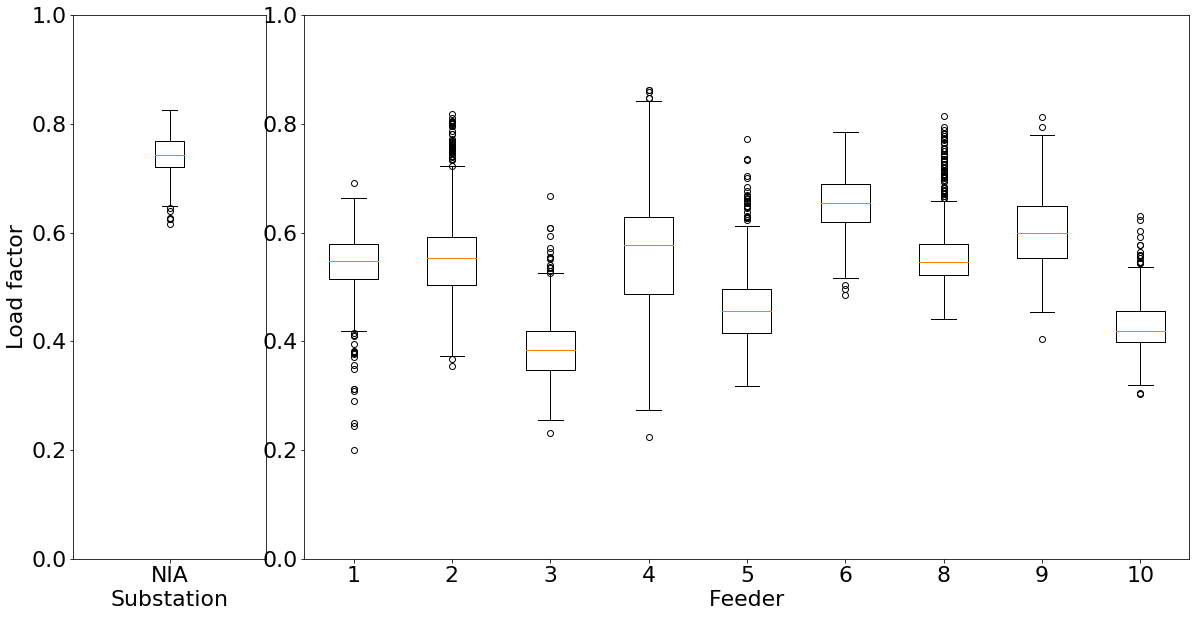

In [26]:
fig = plt.figure(1)
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(1,5)

ax1 = plt.subplot2grid((1,5), (0,0), colspan=1, rowspan=1)
data=[x for x in list(df_AMR_data['LF_SUB']) if x is not "None"]
ax1.boxplot(data)
ax1.set_ylim(0,1)
ax1.set_xticklabels(['NIA'])
ax1.set_xlabel('Substation')
ax1.set_ylabel('Load factor')

ax2 = plt.subplot2grid((1,5), (0,1), colspan=5, rowspan=1)
data=[[x for x in list(df_AMR_data['LF_OUT{}'.format(feeder)]) if x is not "None"] for feeder in ['01','02','03','04','05', '06','08','09','10']]
ax2.boxplot(data)
ax2.set_ylim(0,1)
ax2.set_xticklabels(['1','2','3','4','5','6','8','9','10'])
ax2.set_xlabel('Feeder')
plt.show()
fig_name = 'plot_LF_SUB_NIA.png'

fig.savefig(fig_name)


# Other substation

In [108]:
#read substation file
with open('raw_files/dict_N1_NIB.json') as json_file:  
    sub_data = json.load(json_file)

dict_keys(['OUT04', 'OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09', 'OUT10', 'CAP1', 'CAP2', 'INC01', 'INC02', 'OUT01', 'OUT02', 'OUT03', 'LINE01', 'TP1', 'TP2', 'LINE02'])


In [109]:
df_NIB=pd.DataFrame()
list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

#create date column
df_NIB['Date']=list(sub_data['OUT01']['P_MW'].keys())

#create feeders data columns
for feeder in list_feeder:
    df_NIB['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIB['Date'])]
    
print(df_NIB.head())

         Date                                          SUB_OUT01  \
0  10/27/2018  [6.801310000000001, 6.801310000000001, 6.80131...   
1   1/11/2019  [6.271208000000001, 6.001156, 6.28121, 6.29121...   
2   9/20/2018  [6.661283, 6.49125, 6.621275, 6.44124000000000...   
3   12/4/2018  [6.201194, 6.081171, 6.411235, 6.49125, 6.5112...   
4   2/18/2019  [5.7611099999999995, 5.6110809999999995, 6.161...   

                                           SUB_OUT02  \
0  [3.6006940000000003, 3.6006940000000003, 3.600...   
1  [3.000578, 2.900559, 3.080594, 3.290634, 3.260...   
2  [3.5906919999999998, 3.250627, 3.240625, 3.450...   
3  [3.260628, 3.1005979999999997, 3.130603, 3.320...   
4  [2.090403, 1.9803819999999999, 1.990384, 1.810...   

                                           SUB_OUT03  \
0  [0.700136, 0.700136, 0.700136, 0.700136, 0.700...   
1  [0.6601279999999999, 0.6601279999999999, 0.530...   
2  [0.530103, 0.710138, 0.530103, 0.730141, 0.550...   
3  [0.8801700000000001, 0.8801

In [110]:
#read substation file
with open('raw_files/dict_N1_NIC.json') as json_file:  
    sub_data = json.load(json_file)

dict_keys(['OUT01', 'OUT02', 'OUT03', 'OUT04', 'OUT05', 'OUT07', 'OUT08', 'OUT09', 'OUT10', 'OUT06', 'CAP1', 'CAP2', 'INC01', 'INC02', 'LINE01', 'LINE02', 'TP1', 'TP2'])


In [111]:
df_NIC=pd.DataFrame()
list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

#create date column
df_NIC['Date']=list(sub_data['OUT01']['P_MW'].keys())

#create feeders data columns
for feeder in list_feeder:
    df_NIC['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIC['Date'])]
    
print(df_NIC.head())

         Date                                          SUB_OUT01  \
0   9/20/2018  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   12/4/2018  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   2/18/2019  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  10/27/2018  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4   1/11/2019  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           SUB_OUT02  \
0  [0.37007199999999996, 0.37007199999999996, 0.3...   
1  [0.120024, 0.120024, 0.120024, 0.120024, 0.120...   
2  [0.37007199999999996, 0.37007199999999996, 0.3...   
3  [0.38007399999999997, 0.38007399999999997, 0.3...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           SUB_OUT03  \
0  [1.850357, 1.850357, 1.850357, 1.850357, 1.850...   
1  [1.9203700000000001, 1.9203700000000001, 1.920...   
2  [1.45028, 1.45028, 1.45028, 1.45028, 1.45028, ...   
3  [1.630315, 1.630315, 1.8203